# Objective
Before building ML models using the UCI Heart-Disease dataset, the following questions are to be clarified in this stage (data exploration).
1. What problem needs solving?
2. What data the dataset contains?
3. Which feature appears more important than the other?
4. What is the expected outcome?

Once, these questions are clarified, we can proceed to next stage.

In [54]:
# Load required libraries.
import pandas as pd
import matplotlib.pyplot as plt;
import seaborn as sns;
from custom_libs import helper
from importlib import reload
import numpy as np
import models.uci_heart_disease_dataset as uci
from models.uci_heart_disease_dataset import UCIHeartDiseaseData

In [55]:
reload(uci)
# The 'uci_heart_disease_dataset' library was created to handle UCI dataset related matters.
# The 'get_standard_features' method returns meaningful names in list[] and can be used in dataframe header.
data = pd.read_csv(uci.UCIHeartDiseaseDataFile.cleveland_processed, names=uci.get_standard_features())

# 303 records and 14 columns.
data.head(5)

,Age,Gender,Chest Pain,BP Systolic,Cholesterol,Blood Sugar,Rest ECG,Exe. Max Heartrate,Exe. Induced Angina,Exe. ST Depression,Exe. ST Segment Slope,Major Vessels,Thalassemia,Target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


# 1. What problem needs solving?
<b>Classify</b> - whether a patient has heart disease based on his/her medical data.

At a glance, it appears to be binary classification problem.\
From the data-dictionary, `Target` is the candidate for the classification. Let's investigate the variable's supportability for <u>binary classification</u> problem.

In [56]:
# Let's see what the 'Target' variable is made of.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    303 non-null    float64
 1   Gender                 303 non-null    float64
 2   Chest Pain             303 non-null    float64
 3   BP Systolic            303 non-null    float64
 4   Cholesterol            303 non-null    float64
 5   Blood Sugar            303 non-null    float64
 6   Rest ECG               303 non-null    float64
 7   Exe. Max Heartrate     303 non-null    float64
 8   Exe. Induced Angina    303 non-null    float64
 9   Exe. ST Depression     303 non-null    float64
 10  Exe. ST Segment Slope  303 non-null    float64
 11  Major Vessels          303 non-null    object 
 12  Thalassemia            303 non-null    object 
 13  Target                 303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB

In [57]:
# From the above, it appears that 'Target' variable has integer data-type.
# Let's investigate further if the integer values are in binary class (1 and 0).
data[uci.UCIHeartDiseaseData.target].value_counts()

Target
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

### Observation:
The `Target` variable cannot support binary classification since it has more than 2 values/classes.

If we understood the original intention from the [data-dictionary](1.0-introduction.ipynb) and the literature:
- Any patient with less than 50% vessel narrowing was marked as `value: 0` -- no heart disease
- Any patient with more than 50% vessel narrowing was marked as `value: 1` -- has heart disease. This was further expanded to 1, 2, 3 and 4 based on affected major vessel.

### Conclusion:
We can safely convert this to a binary classification problem by replacing any values of target variable other than `0` to `1`. This logically simplifies that any patient with vessel narrowing more than 50% is suspected to have heart-disease (without distorting the original meaning much).

In [58]:
# Convert any values in target variable other than `0` to `1` - to support binary classification problem.
# The sum of 1, 2, 3 and 4 classes should total up to 55 + 36 + 35 + 13 = 139.
data.loc[data[uci.UCIHeartDiseaseData.target]!=0,uci.UCIHeartDiseaseData.target]=1
data[uci.UCIHeartDiseaseData.target].value_counts()

Target
0    164
1    139
Name: count, dtype: int64

## 2. What data-types the dataset contains?
We got the basic idea about the data types from the [data-dictionary](1.0-introduction.ipynb). let's investigate and verify further the content.

In [ ]:
# The dictionary indicated all processed data is in numerical format. Let's investigate.
data.info()

In [ ]:
# There are 11 numerical (float and int) data, and two objects ('Major Vessels' and 'Thalassemia'). This 2 objects were not documented in data-dictionary.
# Let's check if there are for missing values (isnull/isna checks for None, NaN or NaT (datetime)).
data.isnull().sum()

In [59]:
# Result shows no missing values. But why the data types for 'Major Vessels' and 'Thalassemia' are not numeric as indicated by data-dictionary?
# Let's investigate further the two objects manually, to identify the missing values.
for item in uci.get_standard_features():
    d = data[item]
    if d.dtype == 'object':
        print(data[item].value_counts())

Major Vessels
0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: count, dtype: int64
Thalassemia
3.0    166
7.0    117
6.0     18
?        2
Name: count, dtype: int64


In [60]:
# 'Major Vessels' and 'Thalassemia' should be numerical. However, it is marked as '?'.
# Let's investigate further on Thalassemia.
data[uci.UCIHeartDiseaseData.thalassemia].value_counts()

Thalassemia
3.0    166
7.0    117
6.0     18
?        2
Name: count, dtype: int64

In [61]:
# Let's check the distribution of the missing value marked as '?' in both features.
data[(data[uci.UCIHeartDiseaseData.thalassemia]=='?') | (data[uci.UCIHeartDiseaseData.major_vessels]=='?')]

,Age,Gender,Chest Pain,BP Systolic,Cholesterol,Blood Sugar,Rest ECG,Exe. Max Heartrate,Exe. Induced Angina,Exe. ST Depression,Exe. ST Segment Slope,Major Vessels,Thalassemia,Target
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,1
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


In [62]:
# From above, it looks like the sum is 6, and they are disjointed (4 from 'Major Vessels' and 2 from 'Thalassemia'):
# Let's see the overall percentage of the missing values.
print(f'[{uci.UCIHeartDiseaseData.major_vessels}] has {round(helper.value_count(data,uci.UCIHeartDiseaseData.major_vessels,
                                                                                '?'),2)}% of \'?\' values.')
print(f'[{uci.UCIHeartDiseaseData.thalassemia}] has {round(helper.value_count(data,uci.UCIHeartDiseaseData.thalassemia,
                                                                                '?'),2)}% of \'?\' values.')

[Major Vessels] has 1.32% of '?' values.
[Thalassemia] has 0.66% of '?' values.


### Observation:
- From the investigation, it appears feature `Major Vessels` and `Thalassemia` have missing values marked as `?`.
- Together there are 6 records (4 from `Major Vessels` and 2 from `Thalassemia`) and they are disjoint.
- The total missing values are less than 2%.

### Conclusion
- There are ~2% missing value in the dataset, cannot impute with 'mean' since it was originally a categorical and important variable - should be dropped to avoid unnecessary data inconsistency.
- Before dropping, other datasets (Long Beach, Hungarian and Switzerland) need to be investigated for similar issue.

### A Brief Investigation on Other Datasets

In [64]:
# Hungarian dataset
reload(uci)
temp_data = pd.read_csv(uci.UCIHeartDiseaseDataFile.hungarian_processed, names=uci.get_standard_features())
for item in uci.get_standard_features():
    if temp_data[item].dtype == 'object':
        print(f'[{item}] has {round(helper.value_count(temp_data,item,'?'),2)}% of ? values.')

[BP Systolic] has 0.34% of ? values.
[Cholesterol] has 7.82% of ? values.
[Blood Sugar] has 2.72% of ? values.
[Rest ECG] has 0.34% of ? values.
[Exe. Max Heartrate] has 0.34% of ? values.
[Exe. Induced Angina] has 0.34% of ? values.
[Exe. ST Segment Slope] has 64.63% of ? values.
[Major Vessels] has 98.98% of ? values.
[Thalassemia] has 90.48% of ? values.


In [65]:
# Long Beach dataset
reload(uci)
temp_data = pd.read_csv(uci.UCIHeartDiseaseDataFile.longbeach_processed, names=uci.get_standard_features())
for item in uci.get_standard_features():
    if temp_data[item].dtype == 'object':
        print(f'[{item}] has {round(helper.value_count(temp_data,item,'?'),2)}% of ? values.')

[BP Systolic] has 28.0% of ? values.
[Cholesterol] has 3.5% of ? values.
[Blood Sugar] has 3.5% of ? values.
[Exe. Max Heartrate] has 26.5% of ? values.
[Exe. Induced Angina] has 26.5% of ? values.
[Exe. ST Depression] has 28.0% of ? values.
[Exe. ST Segment Slope] has 51.0% of ? values.
[Major Vessels] has 99.0% of ? values.
[Thalassemia] has 83.0% of ? values.


In [66]:
# Switzerland dataset
reload(uci)
temp_data = pd.read_csv(uci.UCIHeartDiseaseDataFile.switzerland_processed, names=uci.get_standard_features())
for item in uci.get_standard_features():
    if temp_data[item].dtype == 'object':
        print(f'[{item}] has {round(helper.value_count(temp_data,item,'?'),2)}% of ? values.')

[BP Systolic] has 1.63% of ? values.
[Blood Sugar] has 60.98% of ? values.
[Rest ECG] has 0.81% of ? values.
[Exe. Max Heartrate] has 0.81% of ? values.
[Exe. Induced Angina] has 0.81% of ? values.
[Exe. ST Depression] has 4.88% of ? values.
[Exe. ST Segment Slope] has 13.82% of ? values.
[Major Vessels] has 95.93% of ? values.
[Thalassemia] has 42.28% of ? values.



### Important Notice!!!
As can be seen from the above brief investigations, other datasets (Long Beach, Hungarian and Switzerland) also contains the `?` character in many of its variables.

This raises a big question on the validity of the processed dataset! This requires a thorough investigation!

### Investigation Summary:
- The processed datasets (Long Beach, Hungarian and Switzerland) was supposed to be clean and usable. Instead, 68% (621/920) of the UCI dataset has missing values which was marked with '?'. This was investigated here [processed dataset investigation](2.1-uci-processed-dataset-investigation.ipynb)
- Since unable to recover data from the processed dataset, preprocessing the original (raw) data files was the subsequent approach. However, as seen here [raw dataset investigation](2.1-uci-processed-dataset-investigation.ipynb), the '?' mark actually originated from the raw file, it had a different value, which was -9 (integer).
- 2/617 was salvaged and saved into `processed.salvaged.data` file to be concatenated into the current DataFrame

### Concatenate Recovered Data into Cleveland

In [82]:
# Let's remove the missing values from processed cleveland before concatenating.
# Let's check the distribution of the missing value marked as '?' in both features.
rf_index = data[(data[uci.UCIHeartDiseaseData.thalassemia]=='?') | (data[uci.UCIHeartDiseaseData.major_vessels]=='?')].index
data.drop(rf_index, inplace=True)
# 303 - 6 = 297
data.shape

(297, 14)

In [83]:
# Read the salvaged data.
salvaged_data = pd.read_csv(uci.UCIHeartDiseaseDataFile.salvaged_standard, names=uci.get_standard_features())
salvaged_data

,Age,Gender,Chest Pain,BP Systolic,Cholesterol,Blood Sugar,Rest ECG,Exe. Max Heartrate,Exe. Induced Angina,Exe. ST Depression,Exe. ST Segment Slope,Major Vessels,Thalassemia,Target
0,56,1,4,120,100,0,0,120,1,1.5,2,0,7,1
1,47,1,4,150,226,0,0,98,1,1.5,2,0,7,1


In [84]:
# Concatenate the salvaged data with processed cleveland data --> 297 + 2 = 299
df = pd.concat([data, salvaged_data])
df.shape

(299, 14)

## 5. Which feature appears more important than the other?
Now that the dataset is combined and clean, let's explore the data for further analysis (with graphs when needed).

In [85]:
# Let's save a copy of the cleansed dataset for building models.
df.to_csv(uci.UCIHeartDiseaseDataFile.cleveland_cleansed, index=False)

In [86]:
# Ideally we should expect both classes in the target variable to have same proportion, i.e. 299/2 = 149.5.
len(df[uci.UCIHeartDiseaseData.target]) / 2

149.5

In [87]:
# Nevertheless, a slight risk variation can be accepted. Let's investigate if the target class in balanced.
df[uci.UCIHeartDiseaseData.target].value_counts()

Target
0    160
1    139
Name: count, dtype: int64

In [88]:
# To get the percentage proportion, let's view the normalized value counts.
# So, the deviation in the distribution is ~4%.
df[uci.UCIHeartDiseaseData.target].value_counts(normalize=True)

Target
0    0.535117
1    0.464883
Name: proportion, dtype: float64

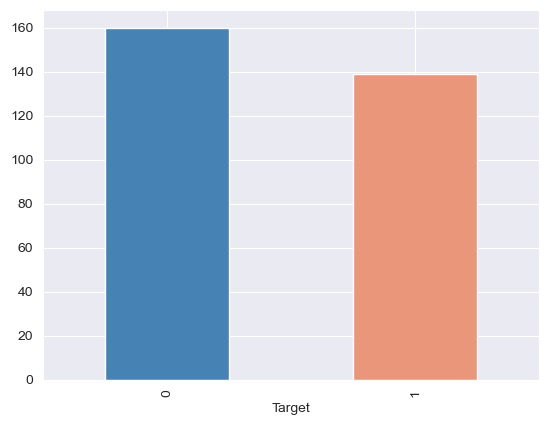

In [89]:
# Let's see the distribution of target variable's class in bar-chart.
df[uci.UCIHeartDiseaseData.target].value_counts().plot(kind="bar", color=['steelblue', 'darksalmon']);

In [90]:
# Let's investigate which features have strong correlation with target.
df.corr()

,Age,Gender,Chest Pain,BP Systolic,Cholesterol,Blood Sugar,Rest ECG,Exe. Max Heartrate,Exe. Induced Angina,Exe. ST Depression,Exe. ST Segment Slope,Major Vessels,Thalassemia,Target
Age,1.000000,-0.093693,0.108095,0.286149,0.199258,0.132752,0.151483,-0.384176,0.092506,0.195929,0.157545,0.362764,0.123229,0.223498
Gender,-0.093693,1.000000,0.012894,-0.065209,-0.202500,0.036869,0.029114,-0.067820,0.148956,0.108107,0.036213,0.088292,0.386678,0.281912
Chest Pain,0.108095,0.012894,1.000000,-0.035708,0.061587,-0.059881,0.057698,-0.344909,0.382309,0.204853,0.154234,0.230434,0.273399,0.412597
BP Systolic,0.286149,-0.065209,-0.035708,1.000000,0.134240,0.179791,0.147124,-0.053320,0.067843,0.191144,0.121500,0.096641,0.138658,0.153849
Cholesterol,0.199258,-0.202500,0.061587,0.134240,1.000000,0.016939,0.172993,0.014894,0.042846,0.033964,-0.015971,0.121907,-0.001852,0.067350
Blood Sugar,0.132752,0.036869,-0.059881,0.179791,0.016939,1.000000,0.071312,-0.002929,-0.004809,0.007252,0.045958,0.153718,0.058679,0.000192
Rest ECG,0.151483,0.029114,0.057698,0.147124,0.172993,0.071312,1.000000,-0.059521,0.071503,0.110738,0.130201,0.133186,0.010839,0.157941
Exe. Max Heartrate,-0.384176,-0.067820,-0.344909,-0.053320,0.014894,-0.002929,-0.059521,1.000000,-0.394229,-0.348089,-0.391992,-0.256831,-0.284226,-0.430108
Exe. Induced Angina,0.092506,0.148956,0.382309,0.067843,0.042846,-0.004809,0.071503,-0.394229,1.000000,0.290835,0.254650,0.140089,0.334347,0.427123
Exe. ST Depression,0.195929,0.108107,0.204853,0.191144,0.033964,0.007252,0.110738,-0.348089,0.290835,1.000000,0.579596,0.291958,0.346212,0.424947


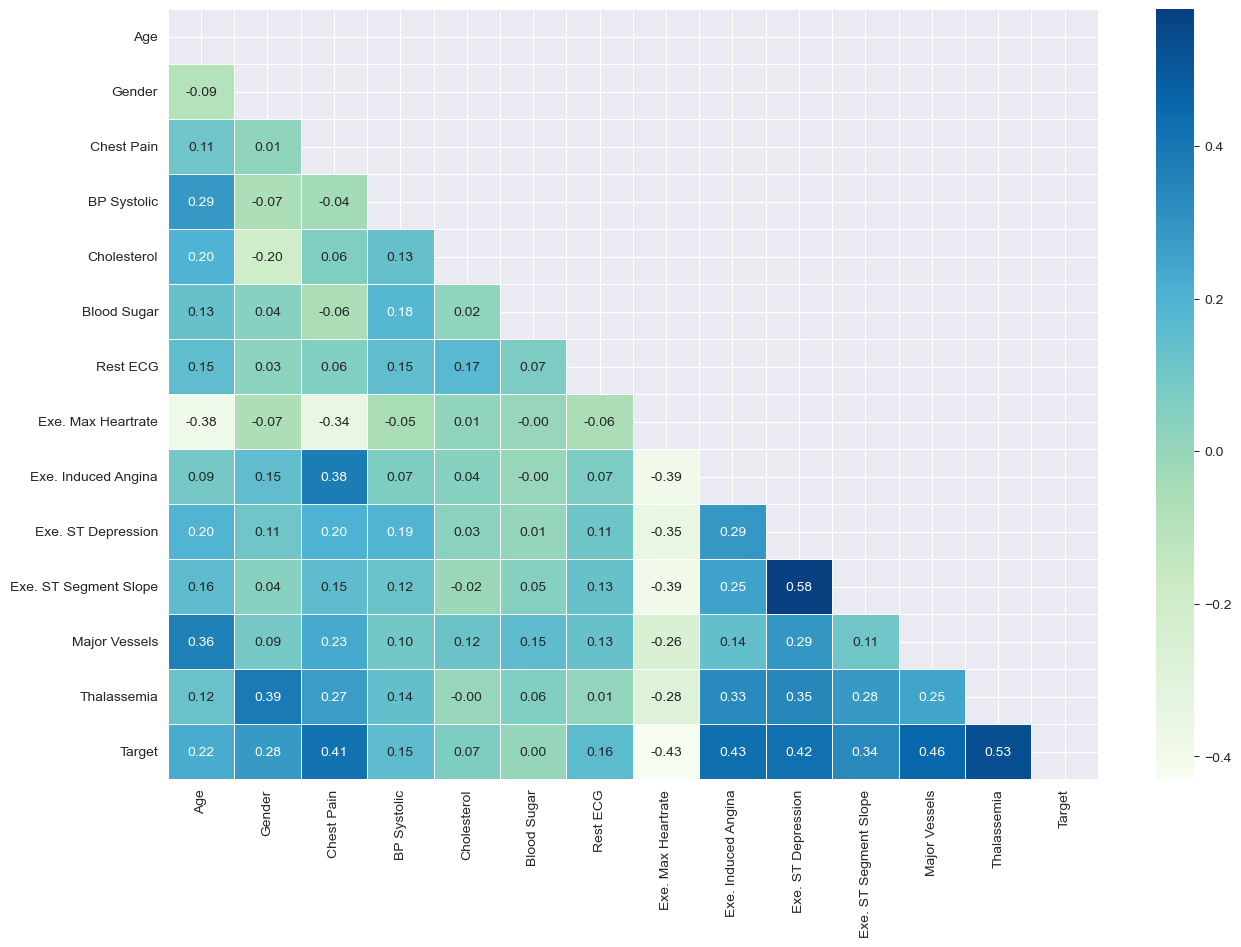

In [91]:
# Let's see the correlation matrix with color intensity spectrum - the darker the blue is, the higher the correlation.
corr_matrix = df.corr(method='pearson')
mask = np.triu(np.ones_like(data.corr()))
plt.figure(figsize=(15, 10))

sns.heatmap(corr_matrix,
            mask=mask,
            annot=True,
            linewidths=0.5,
            fmt= ".2f",
            cmap="GnBu");

### 5.1 Feature Correlation
By eyeballing the chart (above), we can conclude the following from the Pearson's correlation.

| Level     |   Positive   |    Negative    |
|:----------|:------------:|:--------------:|
| Strong    |  0.70 to 1   |  -0.70 to -1   |
| Moderate  | 0.30 to 0.70 | -0.30 to -0.70 |
| Weak      |  0 to 0.30   |   0 to -0.30   |

If we apply the <u>general rules for classifying correlation</u> (using the table above), we observe:
* Features have <u>only moderate correlation</u> between each other and target variable.
#### Positive correlation - positive linear relationship
* Six features has moderate <u>postive correlation to target</u> variable:
1. thal (0.53)
2. ca (0.46)
3. oldpeak (0.42)
4. exang (0.42)
5. cp (0.41)
6. slope (0.33)
* Six features has moderate <u>positive correlation between variables</u>:
1. oldpeak and slope (0.58)
2. sex and thal (0.38)
3. cp and exang (0.38)
4. age and ca (0.36)
5. oldpeak and thal (0.34)
6. exang and thal (0.33)
#### Negative correlation - negative (inverse) linear relationship
* One feature has moderate <u>negative correlation to target</u> variable:
1. thalach (-0.42)
* Six features has moderate <u> negative correlation between variables</u>:
1. age and thalach (-0.39)
2. thalach and slope (-0.39)
3. thalach and exang (-0.38)
4. thalach and oldpeak (-0.35)
2. cp and thalach (-0.34)
3. thalach and thal (-0.27)
4. thalach and ca (-0.27)

### Further investigation needed
We applied pearson's correlation to identify the correlation. We also need to investigate the following to ensure :
- both variables are quantitative
- variables are normally distributed
- no outliers
* Let's find the top 3 variables and investigate:
1. oldpeak and slope (0.58)
2. thal and target (0.53)
3. ca and target (0.42)
* And, one negative correlation:
1. thalach and target (-0.42)

In [92]:
# The curve is slightly right skewed. Mean and median also be slightly on the right.
reload(helper)
helper.draw_histogram_density_curve(df,'trestbps')

AttributeError: module 'custom_libs.helper' has no attribute 'draw_histogram_density_curve'

In [ ]:
df['trestbps'].describe()

In [ ]:
Q3 = df['trestbps'].quantile(0.75)